In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearning_model import plot_learning_curves,EarlyStopping,ModelSaver
from deeplearning_model import train_classification_model,evaluate_classification_model

In [2]:
!mkdir ./competitions
!cd ./competitions

/bin/bash: line 1: cd: ./content: No such file or directory


In [6]:
!mkdir ./cifar-10
!cd ./content

mkdir: cannot create directory ‘./cifar-10’: File exists
/bin/bash: line 1: cd: ./content: No such file or directory


In [4]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 996.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 32.9 MB/s eta 0:00:00


In [8]:
#!pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [9]:
!ls competitions/cifar-10/train|wc -l

50000


# 加载数据并处理为tensor

In [10]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
])

# 把数据集划分为训练集45000和验证集5000，并给DataLoader

In [11]:

# 加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"
#img_dir = r"D:\cifar-10\train\train"
#labels_file = r"D:\cifar-10\trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


In [12]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
# cal_mean_std(train_dataset)

In [13]:

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 搭建InceptionNet模型

In [14]:
import torch
import torch.nn as nn

class InceptionBlockV1(nn.Module):
    """
    Inception V1 模块
    """
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        """
        参数说明:
            in_channels: 输入通道数
            out_1x1: 1x1卷积输出通道数
            red_3x3: 3x3卷积前1x1降维卷积输出通道数
            out_3x3: 3x3卷积输出通道数
            red_5x5: 5x5卷积前1x1降维卷积输出通道数
            out_5x5: 5x5卷积输出通道数
            out_pool: 池化后1x1卷积输出通道数
        """
        super().__init__()
        # 1x1卷积分支，输出64个通道
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1卷积+3x3卷积分支，先减少到96个通道，再卷积为128个通道
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1卷积+5x5卷积分支，先减少到16个通道，再卷积为32个通道
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(inplace=True)
        )

        # 3x3最大池化+1x1卷积分支，先池化后卷积输出32个通道
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # 分别经过四个分支
        branch1 = self.branch1(x)  # 1x1卷积分支
        branch2 = self.branch2(x)  # 1x1+3x3卷积分支
        branch3 = self.branch3(x)  # 1x1+5x5卷积分支
        branch4 = self.branch4(x)  # 池化+1x1卷积分支

        # 拼接四个分支的输出，通道维度(dim=1)上拼接
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)  # 返回拼接后的输出


In [15]:

# InceptionNet-V1主干网络mx模型类
class InceptionNetV1(nn.Module):
    def __init__(self, num_classes=10, relu='relu'):
        """
        参数:
            num_classes: 分类类别数，默认为10（CIFAR-10）
            relu: 激活函数类型，'relu'或'selu'
        """
        super().__init__()
        # 中文注释：根据relu参数选择激活函数
        if relu == 'selu':
            self.activation = nn.SELU(inplace=True)
        else:
            self.activation = nn.ReLU(inplace=True)

        # 中文注释：初始卷积层，先用5x5卷积获取更大感受野，再用3x3卷积
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),  # 5x5卷积，保持输入尺寸，若图片
            nn.MaxPool2d(kernel_size=3, stride=2),  # 池化层，尺寸减半
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 3x3卷积，进一步提取特征
            nn.BatchNorm2d(64),
            self._get_activation(),
            nn.MaxPool2d(kernel_size=3, stride=1)  # 池化层
        )

        # Inception模块堆叠
        # 第一组Inception模块
        # 中文注释：第一组Inception模块
        self.inception3a = InceptionBlockV1(64, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlockV1(256, 128, 128, 192, 32, 96, 64)
        # 池化层
        self.maxpool1 = nn.MaxPool2d(2, 2)  # 中文注释：尺寸减半

        # 第二组Inception模块
        # 中文注释：第二组Inception模块
        self.inception4a = InceptionBlockV1(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlockV1(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlockV1(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlockV1(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlockV1(528, 256, 160, 320, 32, 128, 128)
        self.maxpool2 = nn.MaxPool2d(2, 2)  # 中文注释：再次尺寸减半

        # 第三组Inception模块
        # 中文注释：第三组Inception模块
        self.inception5a = InceptionBlockV1(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlockV1(832, 384, 192, 384, 48, 128, 128)

        # 全局平均池化
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 输出(batch, 通道, 1, 1)

        # 分类器
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)  # 1024为最后Inception输出通道数

        # 中文注释：InceptionNet-V1网络结构适配CIFAR-10，包含多个Inception模块和全局平均池化

    def _get_activation(self):
        # 中文注释：返回激活函数实例
        return self.activation

    def forward(self, x):
        # stem
        x = self.stem(x)
        # 第一组Inception
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool1(x)
        # 第二组Inception
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool2(x)
        # 第三组Inception
        x = self.inception5a(x)
        x = self.inception5b(x)
        # 全局平均池化
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # 展平成(batch, 1024)
        x = self.dropout(x)
        x = self.fc(x)
        return x  # 输出分类结果

In [16]:
# 实例化模型
model = InceptionNetV1(    )

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [17]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 5888602
模型总参数量: 5888602

各层参数量明细:
stem.0.weight: 4800 参数
stem.0.bias: 64 参数
stem.2.weight: 36864 参数
stem.2.bias: 64 参数
stem.3.weight: 64 参数
stem.3.bias: 64 参数
inception3a.branch1.0.weight: 4096 参数
inception3a.branch1.0.bias: 64 参数
inception3a.branch1.1.weight: 64 参数
inception3a.branch1.1.bias: 64 参数
inception3a.branch2.0.weight: 6144 参数
inception3a.branch2.0.bias: 96 参数
inception3a.branch2.1.weight: 96 参数
inception3a.branch2.1.bias: 96 参数
inception3a.branch2.3.weight: 110592 参数
inception3a.branch2.3.bias: 128 参数
inception3a.branch2.4.weight: 128 参数
inception3a.branch2.4.bias: 128 参数
inception3a.branch3.0.weight: 1024 参数
inception3a.branch3.0.bias: 16 参数
inception3a.branch3.1.weight: 16 参数
inception3a.branch3.1.bias: 16 参数
inception3a.branch3.3.weight: 12800 参数
inception3a.branch3.3.bias: 32 参数
inception3a.branch3.4.weight: 32 参数
inception3a.branch3.4.bias: 32 参数
inception3a.branch4.1.weight: 2048 参数
inception3a.branch4.1.bias: 32 参数
inception3a.branch4.2.weight: 32 参数
incep

# 设置交叉熵损失函数，SGD优化器

In [18]:
# 定义损失函数和优化器
from torchvision.models import ResNet


loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

model = InceptionNetV1()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cuda:0
训练开始，共35200步


  0%|          | 0/35200 [00:00<?, ?it/s]

早停触发!
80.1400
早停: 在16000 步


In [20]:
history['val'][-10:-1]

[{'loss': 0.7988115711212158, 'acc': 78.72, 'step': 11500},
 {'loss': 0.9189668428421021, 'acc': 77.28, 'step': 12000},
 {'loss': 0.8651242225646972, 'acc': 78.32, 'step': 12500},
 {'loss': 0.8346926387786865, 'acc': 78.64, 'step': 13000},
 {'loss': 0.8163467240810395, 'acc': 80.14, 'step': 13500},
 {'loss': 0.943292449760437, 'acc': 77.56, 'step': 14000},
 {'loss': 0.8292272993564606, 'acc': 79.62, 'step': 14500},
 {'loss': 0.8506329380989075, 'acc': 79.4, 'step': 15000},
 {'loss': 1.2715815608978271, 'acc': 72.04, 'step': 15500}]

# 绘制损失曲线和准确率曲线

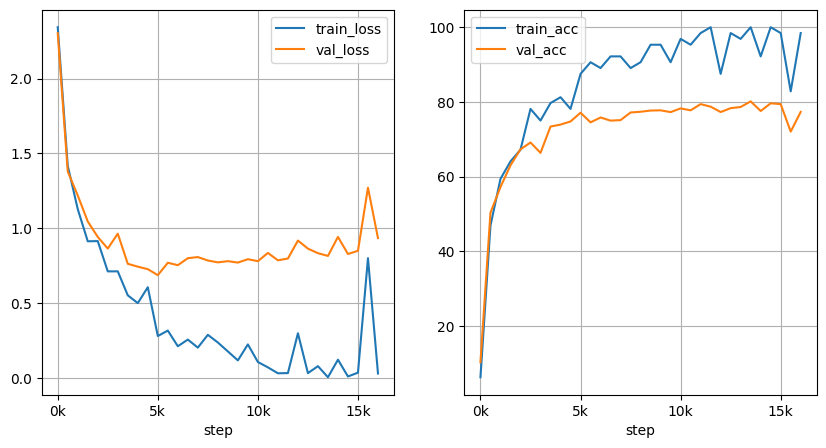

In [21]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [22]:
a =py7zr.SevenZipFile(r'./test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

KeyboardInterrupt: 

In [ ]:
!ls competitions/cifar-10/test|wc -l

In [ ]:
# 导入所需库
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm

# 定义测试数据集类
class CIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        初始化测试数据集

        参数:
            img_dir: 测试图片目录
            transform: 图像预处理变换
        """
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 提取图像ID（文件名去掉扩展名）
        img_id = int(os.path.splitext(self.img_files[idx])[0])

        return image, img_id

# 定义预测函数
def predict_test_set(model, img_dir, labels_file, device, batch_size=64):
    """
    预测测试集并生成提交文件

    参数:
        model: 训练好的模型
        img_dir: 测试图片目录
        labels_file: 提交模板文件路径
        device: 计算设备
        batch_size: 批处理大小
    """
    # 图像预处理变换（与训练集相同）
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
    ])

    # 创建测试数据集和数据加载器
    test_dataset = CIFAR10TestDataset(img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # 设置模型为评估模式
    model.eval()

    # 读取提交模板
    submission_df = pd.read_csv(labels_file)
    predictions = {}

    # 使用tqdm显示进度条
    print("正在预测测试集...")
    with torch.no_grad():
        for images, img_ids in tqdm.tqdm(test_loader, desc="预测进度"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #取最大的索引，作为预测结果

            # 记录每个图像的预测结果
            for i, img_id in enumerate(img_ids):
                predictions[img_id.item()] = predicted[i].item() #因为一个批次有多个图像，所以需要predicted[i]

    # 定义类别名称
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # 将数值标签转换为类别名称
    labeled_predictions = {img_id: class_names[pred] for img_id, pred in predictions.items()}

    # 直接创建DataFrame
    submission_df = pd.DataFrame({
        'id': list(labeled_predictions.keys()),
        'label': list(labeled_predictions.values())
    })
    # 按id列排序
    submission_df = submission_df.sort_values(by='id')

    # 检查id列是否有重复值
    has_duplicates = submission_df['id'].duplicated().any()
    print(f"id列是否有重复值: {has_duplicates}")
    # 保存预测结果
    output_file = 'cifar10_submission.csv'
    submission_df.to_csv(output_file, index=False)
    print(f"预测完成，结果已保存至 {output_file}")

# 执行测试集预测
img_dir = r"competitions/cifar-10/test"
labels_file = r"./sampleSubmission.csv"
predict_test_set(model, img_dir, labels_file, device, batch_size=128)


In [ ]:
!head -10 cifar10_submission.csv